In [1]:
import numpy as np

import dataset
import dataset_misc1d
from backprop import backprop
from backprop import lpbackprop
from backprop import jump_backprop
from backprop import constraints
from backprop import utils

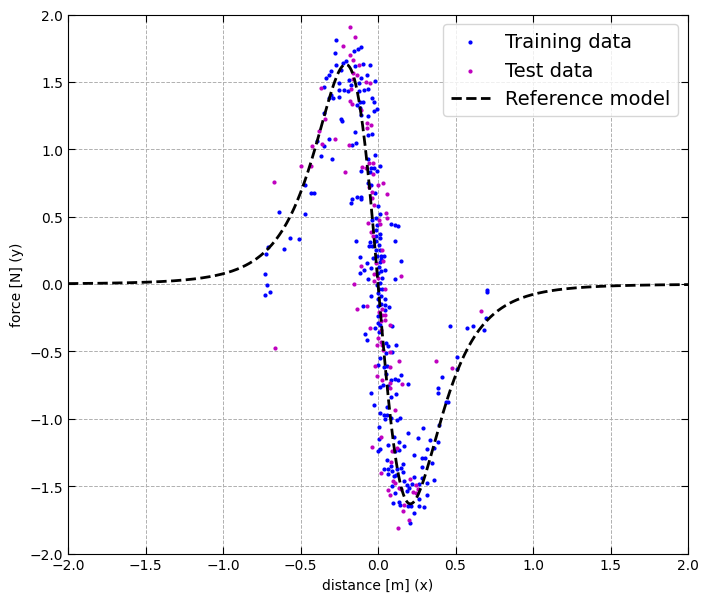

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()

#S.sample(size=250, noise=0.03, mesh=False)
S.load('../data/magman.csv')
S.split(train_size=0.7, randstate=0)
S.get_plotter().plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A')
unknown_stree_b = backprop.UnknownSyntaxTree('B')
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)
#stree     = backprop.SyntaxTreeGenerator().create_random(5)[0]
stree_pr  = stree.diff().simplify()
stree_pr2 = stree_pr.diff().simplify()
stree_map = {(): stree, (0,): stree_pr, (0,0): stree_pr2}
print(str(stree))
print(str(stree_pr))
print(str(stree_pr2))

(A(x) / B(x))
(((A'(x) * B(x)) - (A(x) * B'(x))) / (B(x) ^ 2))
((((((A''(x) * B(x)) + (A'(x) * B'(x))) - ((A'(x) * B'(x)) + (A(x) * B''(x)))) * (B(x) ^ 2)) - (((A'(x) * B(x)) - (A(x) * B'(x))) * ((2 * B(x)) * B'(x)))) / (B(x) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_eval = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_eval
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()
    
    hist, __best_unkn_models, __best_eval = jump_backprop.jump_backprop(stree_map, synth_unkn_models, S_train, S_test, max_rounds=2)
    hist_set.append(hist)

    if best_eval is None or __best_eval.better_than(best_eval):
        best_unkn_models = __best_unkn_models
        best_eval = __best_eval

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)

--- On Synth ---
B(x) =
-1.00000000366454*x**6 - 1.00000000030492*x**4 - 1.00000000034051
A(x) =
1.00000000050222*x

--- On Synth ---
B(x) =
-1.00000000366454*x**6 - 1.00000000030492*x**4 - 1.00000000034051
A(x) =
1.000000000123*x**5 + 1.00000000048793*x**3 + 1.00000000020298*x

--- On Synth ---
B(x) =
1.00000000366454*x**6 + 1.00000000030492*x**4 + 1.00000000034051
A(x) =
-1.00000000050222*x

--- On Synth ---
B(x) =
1.00000000366454*x**6 + 1.00000000030492*x**4 + 1.00000000034051
A(x) =
-1.000000000123*x**5 - 1.00000000048793*x**3 - 1.00000000020298*x



(True, <backprop.lpbackprop.AspModelCost at 0x1b11cf05f90>)

--- Best Syntax Tree ---


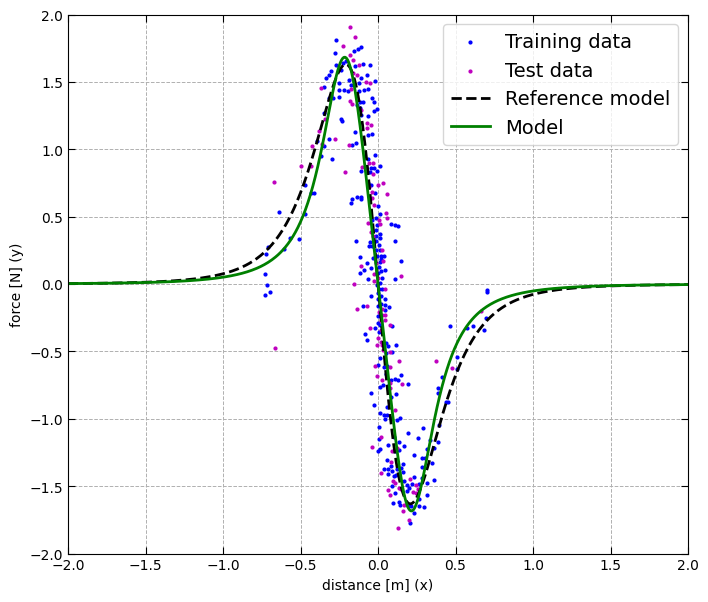

{'mse0': 7.726570515199575e-05, 'mse1': 0.03022350404165014, 'mse2': 10.27020024676625}
Training
	mse: 0.26992628595288876
	rmse: 0.5195443060537654
	r2: 0.74226964084896
Testing
	mse: 0.31550605984569186
	rmse: 0.5616992610335996
	r2: 0.703394306097312
Knowledge
	mse0: 7.726570515199575e-05
	mse1: 0.03022350404165014
	mse2: 10.27020024676625



In [5]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_eval is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
#import sympy
#print(sympy.print_latex(stree.to_sympy()))
#print(best_eval)
S.get_plotter().plot(width=8, height=7, model=stree)

k_eval = S.knowledge.evaluate(stree_map)
print(k_eval)
print(best_eval)


--- Pull from A(x) ---


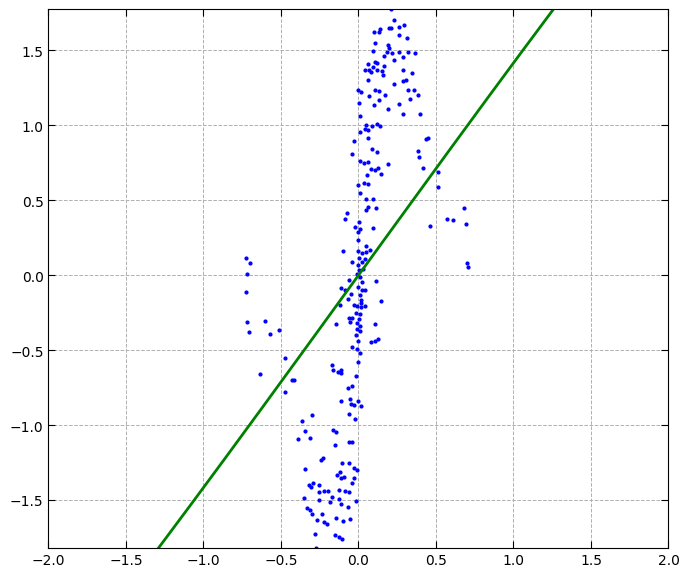

Model:
2.85180356466436e-5*x**5 - 0.00950601190749809*x**3 + 1.42590179567438*x
Coeffs Softmax:
[0.11502505 0.11502733 0.11502505 0.11426581 0.11502505 0.31060667
 0.11502505]
Coeffs:
[ 0.00000000e+00  2.85180356e-05  0.00000000e+00 -9.50601191e-03
  0.00000000e+00  1.42590180e+00  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---


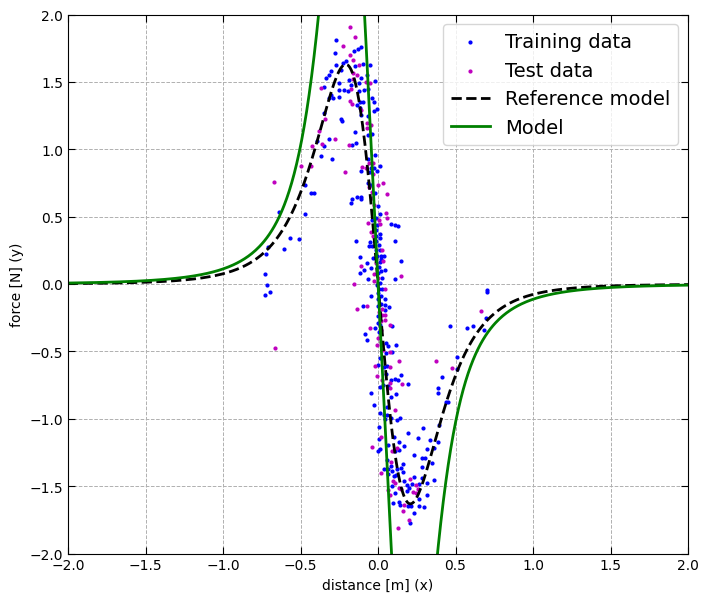



--- Pull from B(x) ---


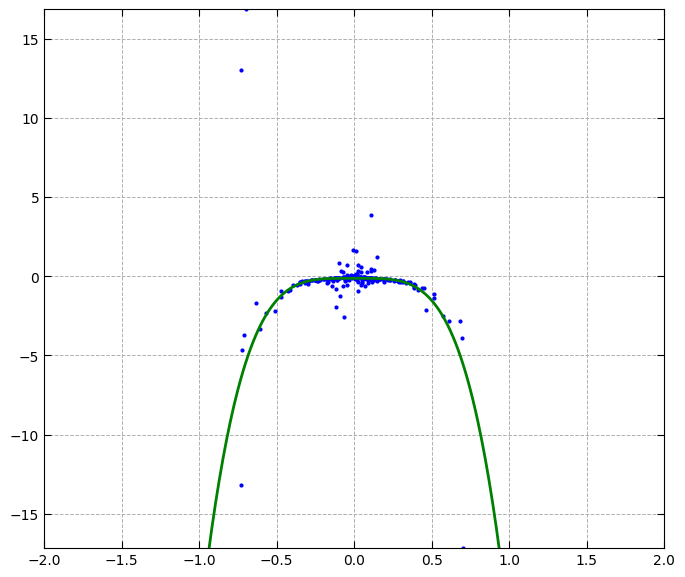

Model:
0.0892080515353957*x**6 - 22.3117638735838*x**4 - 0.130930636901072
Coeffs Softmax:
[0.15767393 0.15704726 0.058005   0.15704726 0.15704726 0.15704726
 0.15613202]
Coeffs:
[  0.08920805   0.         -22.31176387   0.           0.
   0.          -0.13093064]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---


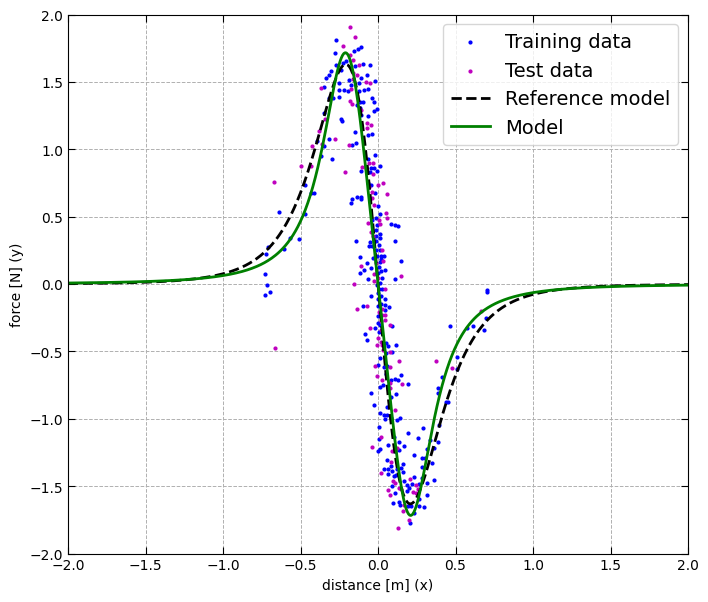



--- Pull from A(x) ---


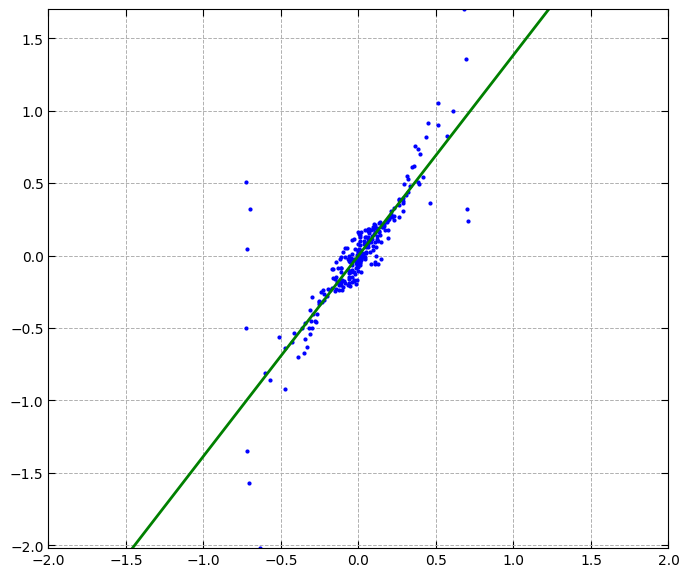

Model:
-1.60557455941568e-8*x**5 + 1.38451326111947*x
Coeffs Softmax:
[0.1147015 0.1147015 0.1147015 0.1147015 0.1147015 0.311791  0.1147015]
Coeffs:
[ 0.00000000e+00 -1.60557456e-08  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.38451326e+00  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---


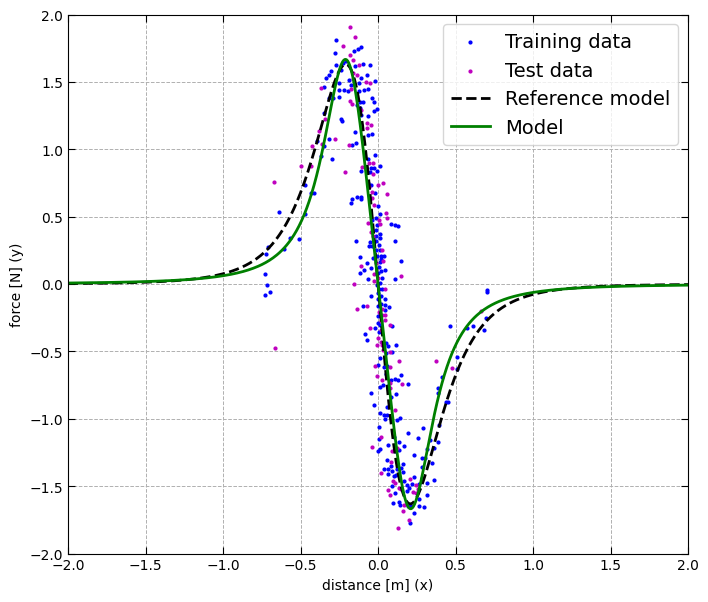



--- Pull from B(x) ---


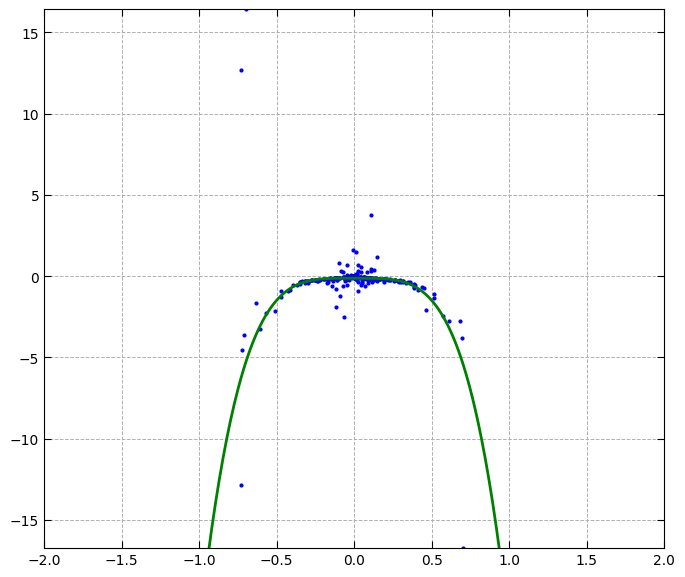

Model:
0.0863043288530045*x**6 - 21.7024706053522*x**4 - 0.127041706456864
Coeffs Softmax:
[0.15767093 0.15704764 0.05800389 0.15704764 0.15704764 0.15704764
 0.15613462]
Coeffs:
[  0.08630433   0.         -21.70247061   0.           0.
   0.          -0.12704171]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---


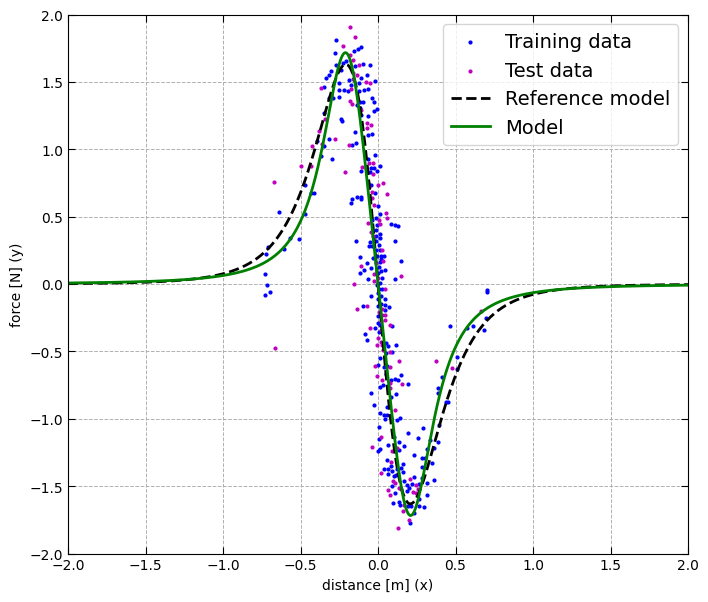



--- Pull from A(x) ---


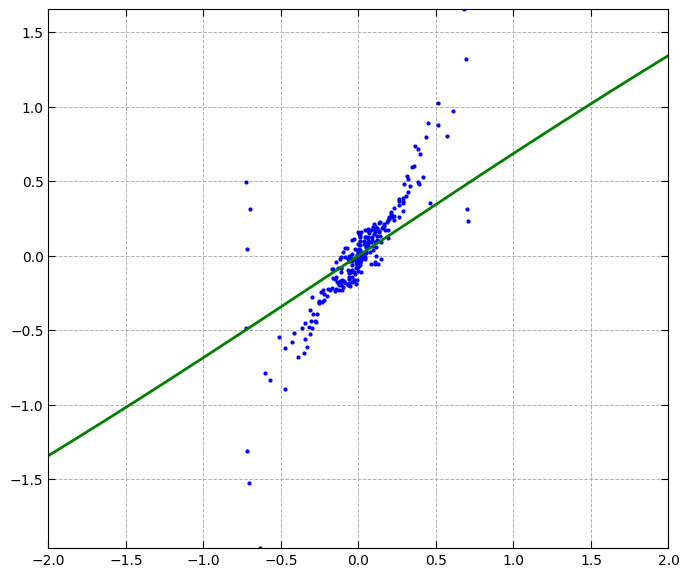

Model:
1.3791898825749e-5*x**5 - 0.00459729948542678*x**3 + 0.689594947299771*x
Coeffs Softmax:
[0.11502505 0.11502733 0.11502505 0.11426581 0.11502505 0.31060667
 0.11502505]
Coeffs:
[ 0.00000000e+00  1.37918988e-05  0.00000000e+00 -4.59729949e-03
  0.00000000e+00  6.89594947e-01  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---
A(-0.20827332) = -0.27383979594616625
A(0.20827332) = 0.27383979594616625
A(-2.00000000) = -1.2589948423886241
A(2.00000000) = 1.2589948423885482

--- Final Model ---


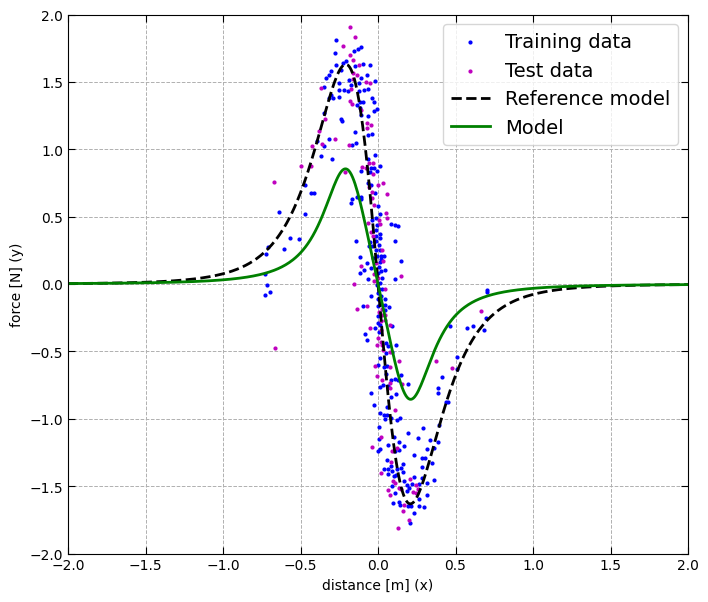



--- Pull from B(x) ---


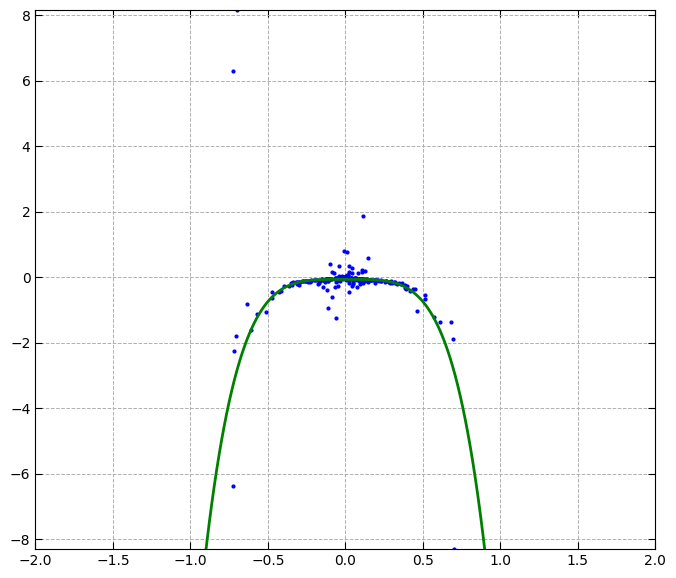

Model:
-3.18285598175952*x**6 - 10.0527078740683*x**4 - 0.0661633300459266
Coeffs Softmax:
[0.11964177 0.16420552 0.06040783 0.16420552 0.16420552 0.16420552
 0.16312832]
Coeffs:
[ -3.18285598   0.         -10.05270787   0.           0.
   0.          -0.06616333]

--- Pulled Eq/Ineq Constraints ---
B(-0.20827332) = -0.08801982664310602
B(0.20827332) = -0.08801982664310602
B(-2.00000000) = -364.612271982835
B(2.00000000) = -364.612271982857

--- Final Model ---


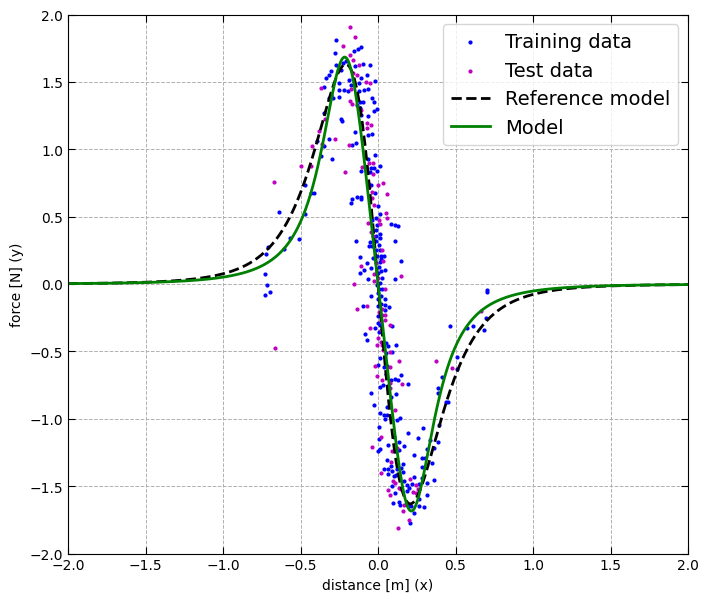



--- Pull from A(x) ---


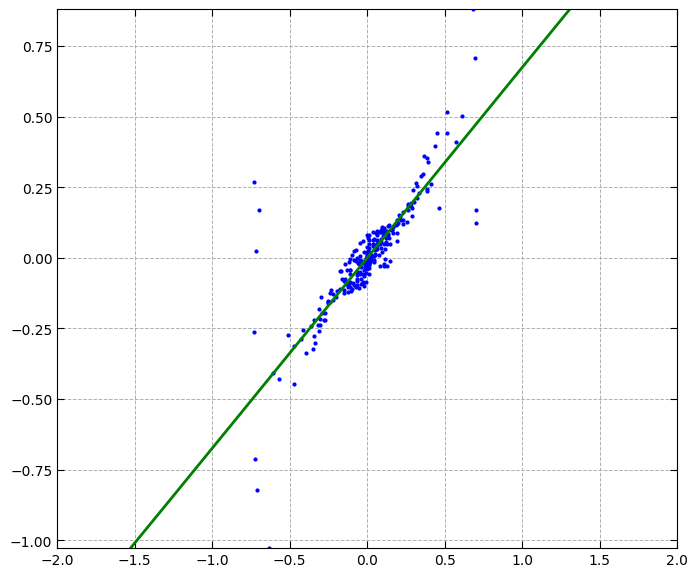

Model:
-8.39178923355e-6*x**5 - 0.000850982112291732*x**3 + 0.675035421581032*x
Coeffs Softmax:
[0.11476325 0.11476182 0.11476325 0.11461885 0.11476325 0.31156633
 0.11476325]
Coeffs:
[ 0.00000000e+00 -8.39178923e-06  0.00000000e+00 -8.50982112e-04
  0.00000000e+00  6.75035422e-01  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---
A(-0.20827332) = -0.139208959175444
A(0.20827332) = 0.139208959175444
A(-2.00000000) = -1.3428528400859203
A(2.00000000) = 1.3428528400858393

--- Final Model ---


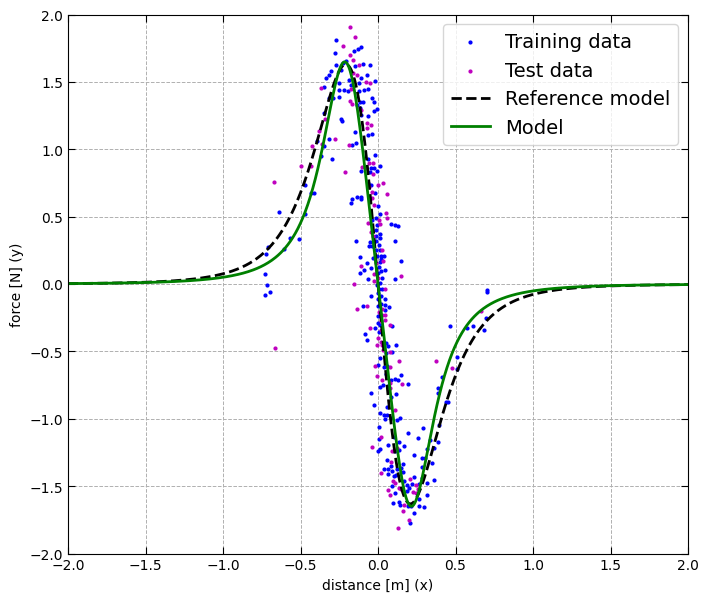



--- Pull from B(x) ---


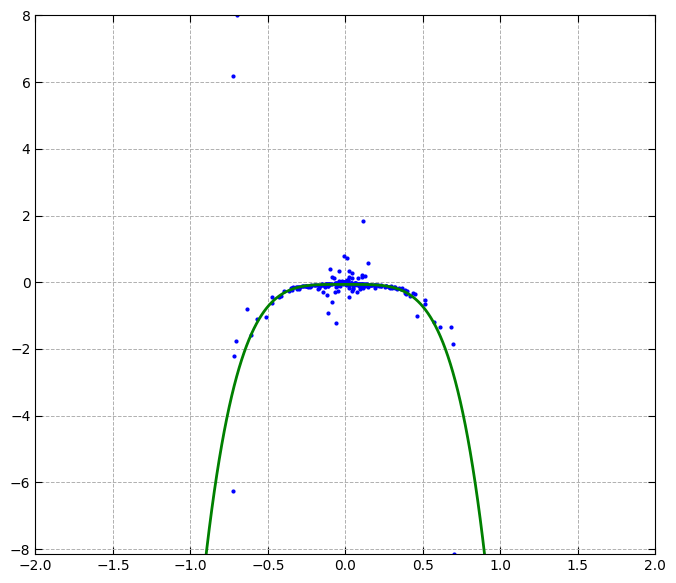

Model:
-3.23943669311221*x**6 - 9.82887200448265*x**4 - 0.0648216470954181
Coeffs Softmax:
[0.11828297 0.16445937 0.06050122 0.16445937 0.16445937 0.16445937
 0.16337833]
Coeffs:
[-3.23943669  0.         -9.828872    0.          0.          0.
 -0.06482165]

--- Pulled Eq/Ineq Constraints ---
B(-0.20827332) = -0.08618165584563282
B(0.20827332) = -0.08618165584563282
B(-2.00000000) = -364.6507218939815
B(2.00000000) = -364.6507218940035

--- Final Model ---


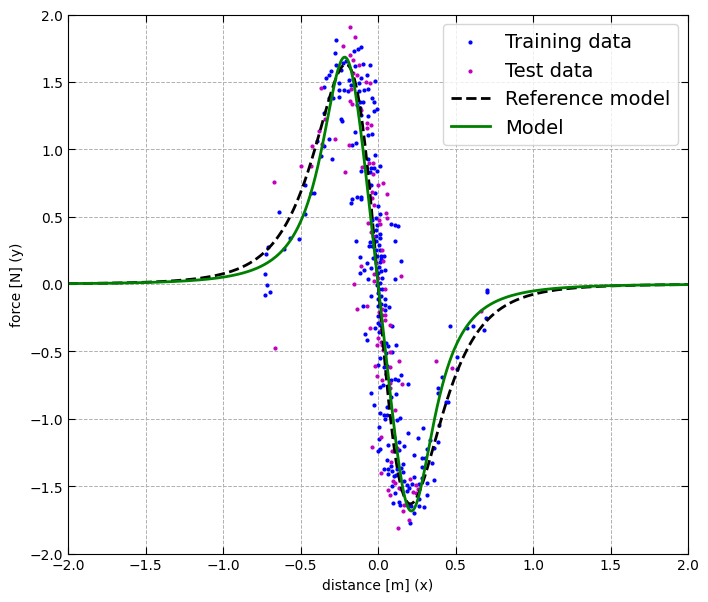

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if not hist_entry.pulled_S.is_empty():
        #y_scaled = utils.scale_y([dp.y for dp in hist_entry.pulled_S.data])
        #for i, dp in enumerate(hist_entry.pulled_S.data):
        #    dp.y = y_scaled[i]
        hist_entry.pulled_S.get_plotter().plot(width=8, height=7, model=hist_entry.fit_model)
        #xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        #plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        #plt.show()
        #model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        model = hist_entry.fit_model
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.get_coeffs())}")
        print(f"Coeffs:\n{model.get_coeffs()}")

    print("\n--- Pulled Eq/Ineq Constraints ---")
    for derivdeg in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[derivdeg].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = str(dp.y) #"{:.8f}".format(dp.y)
            prime_sign = "'" * derivdeg
            constrmap.add(hist_entry.model_name + prime_sign, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{prime_sign}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")

    print("\n--- Final Model ---") 
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    model_eval = S.evaluate(stree.compute_output)
    #print(model_eval)
    
    S.get_plotter().plot(width=8, height=7, model=stree)

    print()